Загружаем данные

In [158]:
import pandas as pd
glass = pd.read_csv('glass.csv')
glass.head()

,RI,Na,Mg,Al,Si,K,Ca,Ba,Fe,Type
0,1.52101,13.64,4.49,1.10,71.78,0.06,8.75,0.0,0.0,1
1,1.51761,13.89,3.60,1.36,72.73,0.48,7.83,0.0,0.0,1
2,1.51618,13.53,3.55,1.54,72.99,0.39,7.78,0.0,0.0,1
3,1.51766,13.21,3.69,1.29,72.61,0.57,8.22,0.0,0.0,1
4,1.51742,13.27,3.62,1.24,73.08,0.55,8.07,0.0,0.0,1


Пропусков нет, все данные числовые

In [159]:
glass.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 214 entries, 0 to 213
Data columns (total 10 columns):
RI      214 non-null float64
Na      214 non-null float64
Mg      214 non-null float64
Al      214 non-null float64
Si      214 non-null float64
K       214 non-null float64
Ca      214 non-null float64
Ba      214 non-null float64
Fe      214 non-null float64
Type    214 non-null int64
dtypes: float64(9), int64(1)
memory usage: 16.8 KB


Делим выборку, обучаем модель случайного леса

In [160]:
from sklearn.model_selection import train_test_split
y = glass['Type']
X = glass.drop('Type',axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [161]:
from sklearn.ensemble import RandomForestClassifier
forest = RandomForestClassifier(n_estimators=100, max_depth=10, max_features=9, n_jobs=-1, random_state=17)
forest.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=10, max_features=9, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
            oob_score=False, random_state=17, verbose=0, warm_start=False)

In [162]:
from sklearn.metrics import accuracy_score
y_pred = forest.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
accuracy

0.86046511627906974

Изучение статистик позволяет предположить наличие выбросов в большинстве переменных

In [163]:
X.describe()

,RI,Na,Mg,Al,Si,K,Ca,Ba,Fe
count,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000
mean,1.518365,13.407850,2.684533,1.444907,72.650935,0.497056,8.956963,0.175047,0.057009
std,0.003037,0.816604,1.442408,0.499270,0.774546,0.652192,1.423153,0.497219,0.097439
min,1.511150,10.730000,0.000000,0.290000,69.810000,0.000000,5.430000,0.000000,0.000000
25%,1.516523,12.907500,2.115000,1.190000,72.280000,0.122500,8.240000,0.000000,0.000000
50%,1.517680,13.300000,3.480000,1.360000,72.790000,0.555000,8.600000,0.000000,0.000000
75%,1.519157,13.825000,3.600000,1.630000,73.087500,0.610000,9.172500,0.000000,0.100000
max,1.533930,17.380000,4.490000,3.500000,75.410000,6.210000,16.190000,3.150000,0.510000


Строим графики

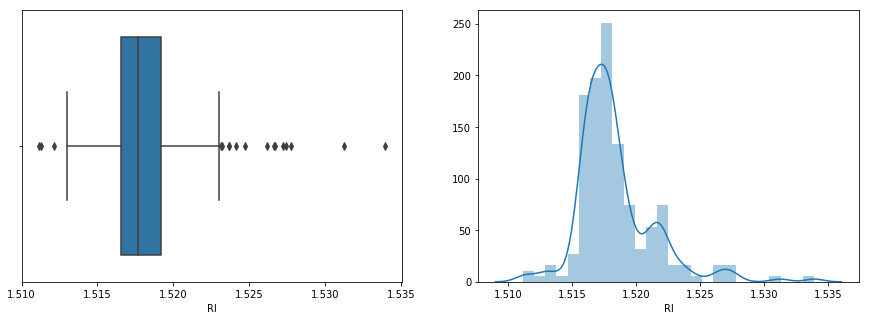

In [109]:
% matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt

def two_plt(col):
    fig, axes = plt.subplots(1, 2, figsize=(15, 5), sharey=False)
    sns.boxplot(data=X, x=col, ax=axes[0])
    sns.distplot(X[col], ax=axes[1], hist=True, kde=True)
    
two_plt('RI')    

Для первой переменной имеются выбросы, распределение близко к нормальному

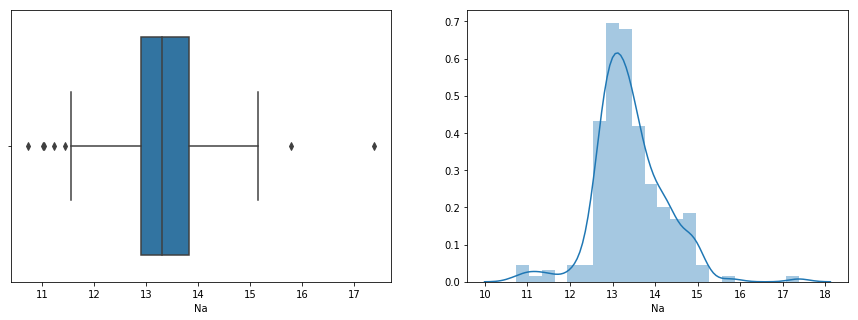

In [110]:
two_plt('Na')

Для второй переменной имеются выбросы, распределение близко к нормальному

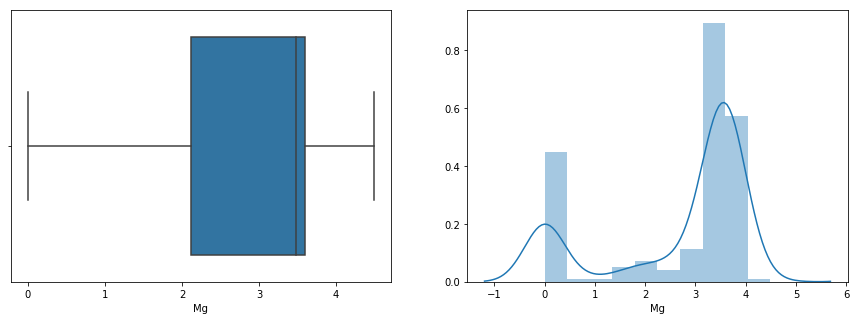

In [111]:
two_plt('Mg')

Для третьей переменной выбросов нет, распределение близко к нормальному

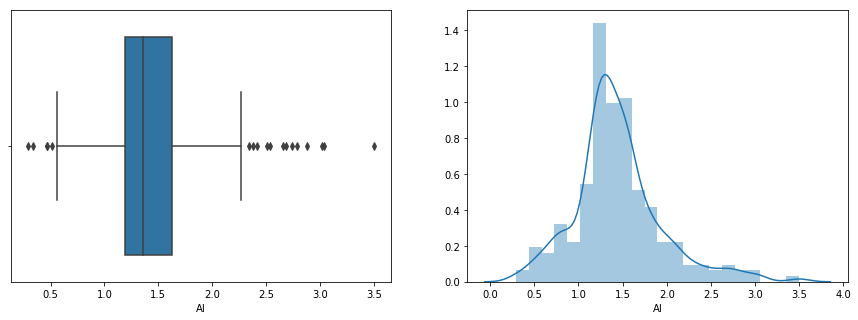

In [112]:
two_plt('Al')

Для четвертой переменной имеются выбросы, распределение близко к нормальному

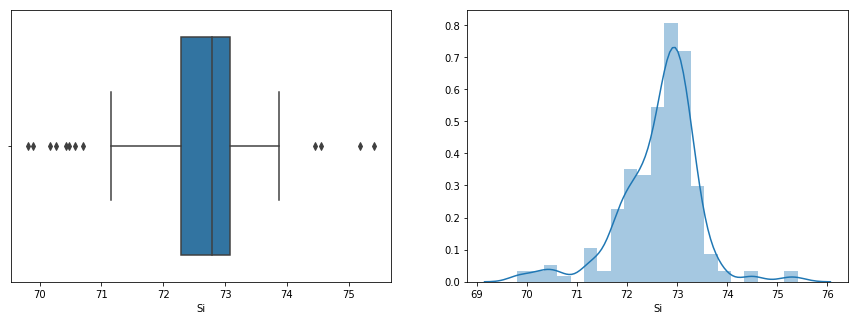

In [113]:
two_plt('Si')

Для пятой переменной имеются выбросы, распределение близко к нормальному

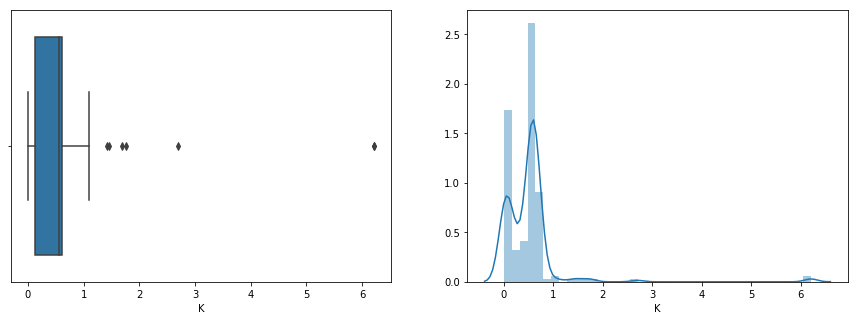

In [114]:
two_plt('K')

Для шестой переменной имеются выбросы, распределение близко к нормальному

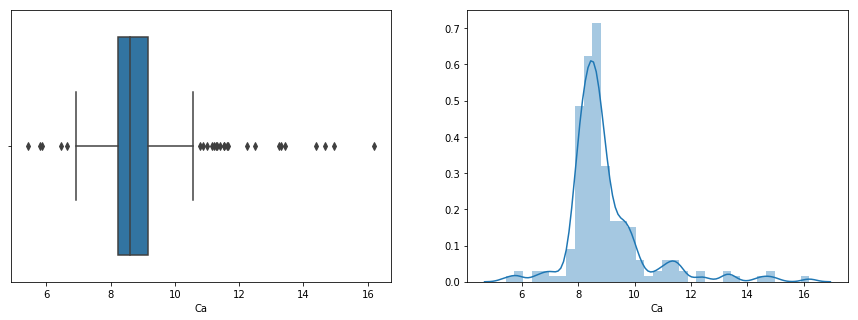

In [115]:
two_plt('Ca')

Для седьмой переменной имеются выбросы, распределение близко к нормальному

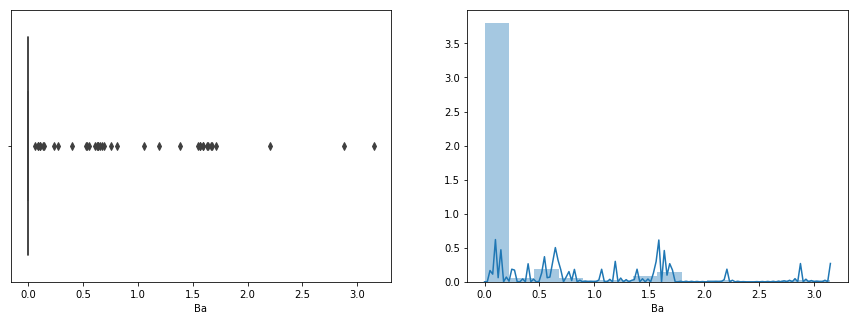

In [116]:
two_plt('Ba')

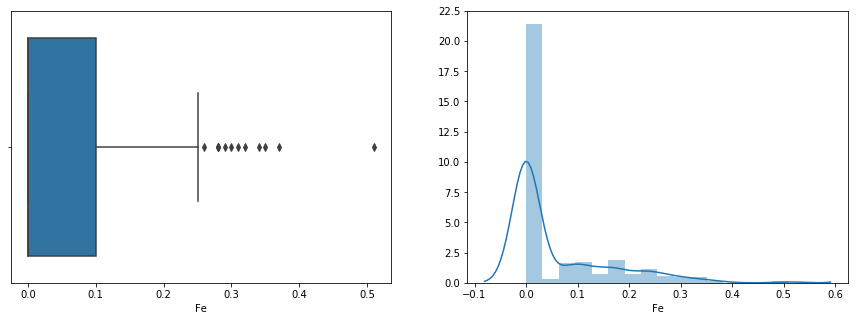

In [117]:
two_plt('Fe')

Две последние переменные имеют не нормальное распределение

Исследуем признаки на выбросы методом Isolation Forest

In [164]:
from sklearn.ensemble import IsolationForest
model = IsolationForest(max_samples = 100, random_state = 42)
model.fit(X)

# создадим столбец с результатом (выброс (-1) или нет (1))
glass['anomaly'] = model.predict(X)
 
# посмотрим на количество выбросов
glass[glass.anomaly == -1].shape[0]

22

Исследуем признаки на выбросы методом Local Outlier Factor

In [165]:
from sklearn.neighbors import LocalOutlierFactor

clf = LocalOutlierFactor(n_neighbors=20, contamination=0.1)
glass['anomaly1'] = clf.fit_predict(X)
glass[glass.anomaly1 == -1].shape[0]

22

Количество совпадающих выбросов для обоих методов

In [166]:
glass[(glass.anomaly1 == -1) & (glass.anomaly == -1)].shape[0]

13

Считаем процент удаляемых записей для каждого класса

In [182]:
glass_gr = glass.groupby('Type').agg('count')
glass_del = glass[(glass.anomaly1 == -1) & (glass.anomaly == -1)].groupby('Type').agg('count')
df = pd.merge(glass_gr, glass_del, left_index=True, right_index=True, how='left').fillna(0)
df['% удаленных записей'] = round(df['anomaly_y'] / df['anomaly_x']*100, 2)
df[['% удаленных записей']]

,% удаленных записей
Type,
1,0.00
2,3.95
3,0.00
5,23.08
6,11.11
7,20.69


Удаляем совпадающие выбросы

In [183]:
glass = glass.drop(glass[(glass.anomaly1 == -1) & (glass.anomaly == -1)].index)

Оставшийся датасет делим на выборки, обучаем модель с теми же параметрами

In [184]:
y = glass['Type']
X = glass.drop(['Type','anomaly','anomaly1'],axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [185]:
forest1 = RandomForestClassifier(n_estimators=100, max_depth=10, max_features=9, n_jobs=-1, random_state=17)
forest1.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=10, max_features=9, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
            oob_score=False, random_state=17, verbose=0, warm_start=False)

In [186]:
y_pred = forest1.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
accuracy

0.73170731707317072

После удаления выбросов метрика ухудшилась. Объясняется это тем, что случайный лес нечувствителен к выбросам, поскольку работают с разделениями. Кроме того, объекты-выбросы могут не попадать в некоторые обучающие подвыборки благодаря бэггингу.

Тем не менее, исследовать данные на выбросы нужно, поскольку за выбросами могут скрываться ошибочные данные.